# Generating animated time series using `xr_animation`

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

## Background
Animations can be a powerful method for visualising change in the landscape across time using satellite imagery. Satellite data from Digital Earth Africa is an ideal subject for animations as it has been georeferenced, processed to analysis-ready surface reflectance, and stacked into a spatio-temporal 'data cube', allowing landscape conditions to be extracted and  visualised consistently across time.

Using the DE Africa functions in `deafrica_tools.plotting`, which are based on `matplotlib.animation` and `xarray`, we can take a time series of Digital Earth Africa satellite imagery and export a visually appealing time series animation that shows how any location in Africa has changed.

## Description
This notebook demonstrates how to:

1. Import a time series of cloud-free satellite imagery from multiple satellites (i.e. Sentinel-2A and -2B) as an xarray dataset
2. Plot the data as a three band time series animation
3. Plot the data as a one band time series animation
4. Export the resulting animations as either a GIF or MP4 file
5. Add custom vector overlays
6. Apply custom image processing functions to each animation frame

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
import skimage.exposure
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import Image

from deafrica_tools.plotting import xr_animation, rgb
from deafrica_tools.datahandling import load_ard

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Animated_timeseries')

## Load satellite data from datacube
We can use the [load_ard](Using_load_ard.ipynb) function to load data from multiple satellites (i.e. Sentinel-2A and -2B), and return a single `xarray.Dataset` containing only observations with a minimum percentage of good quality pixels. 
This will allow us to create a visually appealing time series animation of observations that are not affected by cloud.

In the example below, we request that the function returns only observations which are 95% free of clouds and other poor quality pixels by specifyinge `min_gooddata=0.95`.

In [3]:
lat, lon = 8.57, -2.4  # Bui Reservoir inlet
buffer = 0.05

x = (lon - buffer, lon + buffer)
y =  (lat + buffer, lat - buffer)

# Create a reusable query
query = {
    'x': x,
    'y': y,
    'time': ('2017-10-10', '2018-01-10'),
    'resolution': (-20, 20)
}

In [4]:
# Load available data
ds = load_ard(dc=dc, 
              products=['s2_l2a'],
              measurements=['red', 'green', 'blue', 'nir_1', 'swir_1', 'swir_2'],
              group_by='solar_day',
              output_crs='epsg:32630', 
              min_gooddata=0.95,
              mask_pixel_quality=True,
              **query)

# Print output data
print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 13 out of 19 time steps with at least 95.0% good quality pixels
Applying pixel quality/cloud mask
Loading 13 time steps
<xarray.Dataset>
Dimensions:      (time: 13, y: 555, x: 552)
Coordinates:
  * time         (time) datetime64[ns] 2017-10-17T10:40:55 ... 2018-01-10T10:...
  * y            (y) float64 9.529e+05 9.529e+05 ... 9.418e+05 9.418e+05
  * x            (x) float64 5.605e+05 5.605e+05 ... 5.715e+05 5.715e+05
    spatial_ref  int32 32630
Data variables:
    red          (time, y, x) float32 440.0 447.0 465.0 ... 526.0 537.0 557.0
    green        (time, y, x) float32 677.0 682.0 690.0 ... 683.0 679.0 668.0
    blue         (time, y, x) float32 250.0 274.0 285.0 ... 547.0 548.0 540.0
    nir_1        (time, y, x) float32 3.098e+03 3.123e+03 ... 446.0 626.0
    swir_1       (time, y, x) float32 1.671e+03 1.696e+03 ... 399.0 442.0
    swir_2       (time, y, x) float32 783.0 775.0 773.0 ... 307.0 311.0 340.0
Attributes:
    crs:           epsg:32630
    grid_mapping:  

To get a quick idea of what the data looks like, we can plot the dataset in true colour using the `rgb` function:

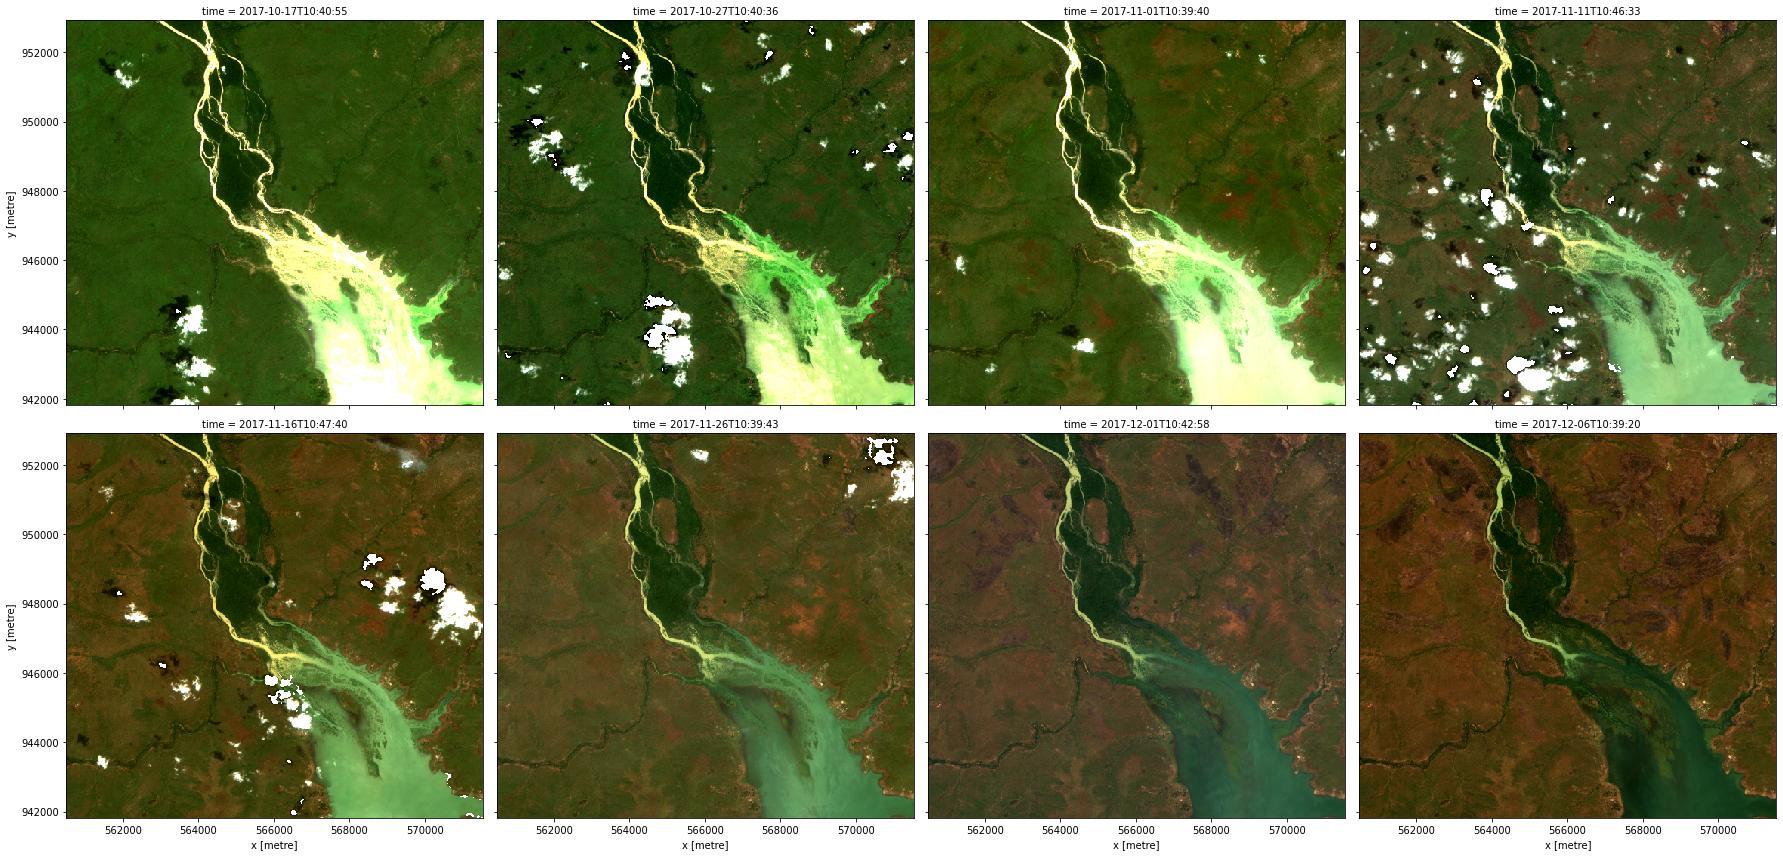

In [5]:
# Plot images from the dataset
rgb(ds, index=list(range(0, 8)))

## Plot time series as a RGB/three band animated GIF
The `xr_animation()` function is based on functionality within `matplotlib.animation`. 
It takes an `xarray.Dataset` and exports a one band or three band (e.g. true or false colour) GIF or MP4 animation showing changes in the landscape across time. 

In the next cell, we will plot the dataset we loaded above as an animated GIF, using the `['red', 'green', 'blue']` satellite bands to generate a true colour RGB animation.  
The interval between the animation frames is set to to 200 milliseconds using `interval`, and the width of the animation to 300 pixels using `width_pixels`.
If these parameters are not specified, the function will use a default `interval` value of 100 milliseconds, and a default `width_pixels` value of 500 pixels.

Exporting animation to animated_timeseries.gif


  0%|          | 0/13 (0.0 seconds remaining at ? frames/s)

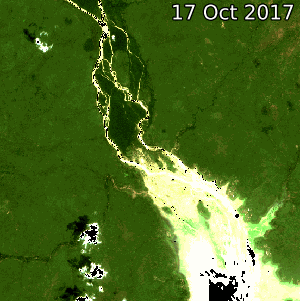

In [6]:
# Produce time series animation of red, green and blue bands
xr_animation(ds=ds, 
             bands=['red', 'green', 'blue'],
             output_path='animated_timeseries.gif',                                
             interval=200, 
             width_pixels=300) 

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')


We can also use different band combinations (e.g. false colour) using `bands`, add additional text using `show_text`, and change the font size using `annotation_kwargs`, which passes a dictionary of values to the matplotlib `plt.annotate` function (see [matplotlib.pyplot.annotate](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html) for options).

The function will automatically select an appropriate colour stretch by clipping the data to remove outliers/extreme values smaller or greater than the 2 and 98th percentiles (e.g. similar to xarray's `robust=True`). This can be controlled further with the `percentile_stretch` parameter. For example, setting `percentile_stretch=(0.01, 0.99)` will apply a colour stretch with less contrast:

Exporting animation to animated_timeseries.gif


  0%|          | 0/13 (0.0 seconds remaining at ? frames/s)

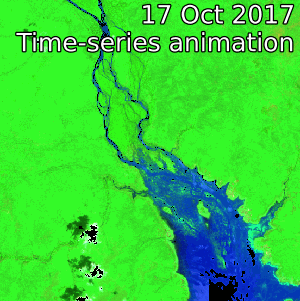

In [7]:
# Produce time series animation of red, green and blue bands
xr_animation(ds=ds,
             bands=['swir_2', 'nir_1', 'green'], 
             output_path='animated_timeseries.gif',
             width_pixels=300,
             show_text='Time-series animation',
             percentile_stretch=(0.01, 0.99),
             annotation_kwargs={'fontsize': 25}) 

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')

### Plotting single band animations
It is also possible to plot a single band image instead of a three band image. 
For example, we could plot an index like the Normalized Difference Water Index (NDWI), which has high values where a pixel is likely to be open water (e.g. NDWI > 0). 

By default the colour bar limits are set based on `percentile_stretch` which will discard outliers/extreme values to optimise the colour stretch (set `percentile_stretch=(0.0, 1.00)` to show the full range of values from min to max).

Exporting animation to animated_timeseries.gif


  0%|          | 0/13 (0.0 seconds remaining at ? frames/s)

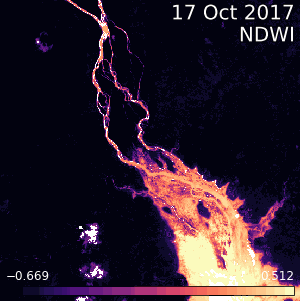

In [8]:
# Compute NDWI using the formula (green - nir) / (green + nir). 
# This will calculate NDWI for every time-step in the dataset:
ds['NDWI'] = ((ds.green - ds.nir_1) / 
              (ds.green + ds.nir_1))

# Produce time series animation of NDWI:
xr_animation(ds=ds, 
             output_path='animated_timeseries.gif',
             bands=['NDWI'], 
             show_text='NDWI', 
             width_pixels=300) 

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')

We can customise animations based on a single band like NDWI by specifying parameters using `imshow_kwargs`, which is passed to the matplotlib [plt.imshow](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) function (see link for options). 
For example, we can use a more appropriate blue colour scheme with `'cmap': 'Blues'`, and set `'vmin': 0.0, 'vmax': 0.5` to overrule the default colour bar limits with manually specified values:

Exporting animation to animated_timeseries.gif


  0%|          | 0/13 (0.0 seconds remaining at ? frames/s)

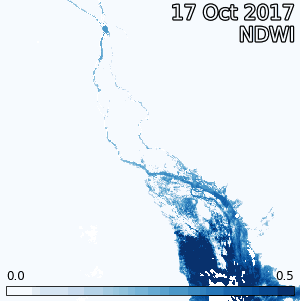

In [9]:
# Produce time series animation using a custom colour scheme and limits:
xr_animation(ds=ds,
             bands='NDWI', 
             output_path='animated_timeseries.gif',
             width_pixels=300,
             show_text='NDWI',
             imshow_kwargs={'cmap': 'Blues', 'vmin': 0.0, 'vmax': 0.5},
             colorbar_kwargs={'colors': 'black'})

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')


One band animations show a colour bar by default, but this can be disabled using `show_colorbar`:

Exporting animation to animated_timeseries.gif


  0%|          | 0/13 (0.0 seconds remaining at ? frames/s)

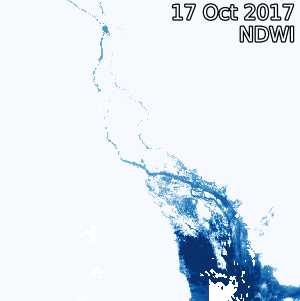

In [10]:
# Produce time series animation using a custom colour scheme and limits:
xr_animation(ds=ds,
             bands='NDWI', 
             output_path='animated_timeseries.gif',
             width_pixels=300,
             show_text='NDWI',
             show_colorbar=False,
             imshow_kwargs={'cmap': 'Blues', 'vmin': 0.0, 'vmax': 0.5})

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')

## Available output formats
The above examples have focused on exporting animated GIFs, but MP4 files can also be generated. The two formats have their own advantages and disadvantages:

* `.mp4`: fast to generate, smallest file sizes and highest quality; suitable for Twitter/social media and recent versions of Powerpoint

* `.gif`: slow to generate, large file sizes, low rendering quality; suitable for all versions of Powerpoint and Twitter/social media

> Note: To preview a `.mp4` file from within JupyterLab, find the file (e.g. 'animated_timeseries.mp4') in the file browser on the left, right click, and select 'Open in New Browser Tab'.

Exporting animation to animated_timeseries.mp4


  0%|          | 0/13 (0.0 seconds remaining at ? frames/s)

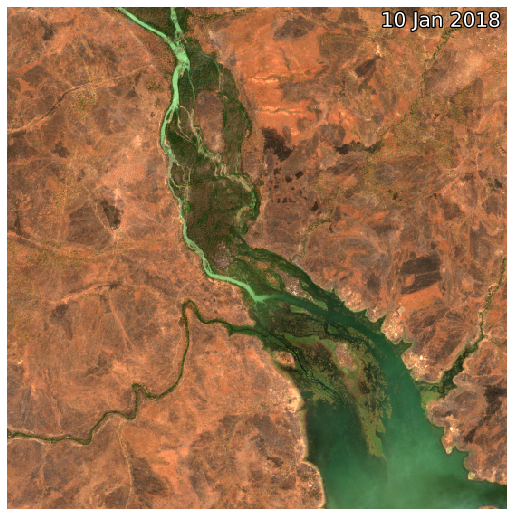

In [11]:
# Animate datasets as a MP4 file
xr_animation(ds=ds, 
             bands=['red', 'green', 'blue'],
             output_path='animated_timeseries.mp4')

## Adding vector overlays

The animation code supports plotting vector files (e.g. ESRI Shapefiles or GeoJSON) over the top of satellite imagery. To do this, we first load the file using geopandas, and pass this to `xr_animation` using the `show_gdf` parameter:


Exporting animation to animated_timeseries.gif


  0%|          | 0/13 (0.0 seconds remaining at ? frames/s)

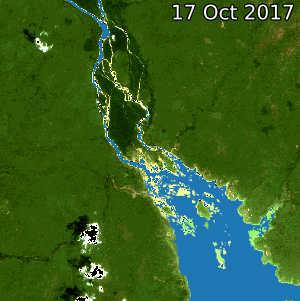

In [12]:
# Get shapefile path
poly_gdf = gpd.read_file('../Supplementary_data/Animated_timeseries/example_polygon.shp')

# Produce time series animation 
xr_animation(ds=ds, 
             bands=['red', 'green', 'blue'],
             output_path='animated_timeseries.gif', 
             width_pixels=300,
             show_gdf=poly_gdf) 

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')

You can customise styling for vector overlays by including a column called `'color'` in the `geopandas.GeoDataFrame` object:

Exporting animation to animated_timeseries.gif


  0%|          | 0/13 (0.0 seconds remaining at ? frames/s)

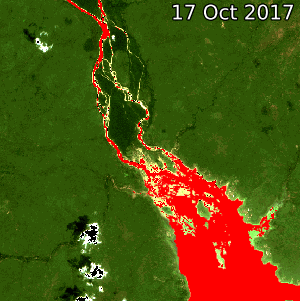

In [13]:
# Assign a colour to the GeoDataFrame
poly_gdf['color'] = 'red'

# Produce time series animation 
xr_animation(ds=ds, 
             bands=['red', 'green', 'blue'],
             output_path='animated_timeseries.gif', 
             width_pixels=300,
             show_gdf=poly_gdf) 

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')

## Plotting vectors by time

It can be useful to plot vector features over the top of imagery at specific times in an animation. For example, in this example we may want to plot different vectors depending on how full our waterbody was during our analysis period.

To do this, we can create new `start_time` and `end_time` columns in our `geopandas.GeoDataFrame` that tell `xr_animation` how long to plot each feature over the top of our imagery:

> **Note**: Dates can be provided in any string format that can be converted using the [pandas.to_datetime()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) function. For example, '2009', '2009-11', '2009-11-01' etc.

In [14]:
# Assign start and end times to each feature
poly_gdf['start_time'] = ['2017-09', '2017-11', '2017-12', '2018-01']
poly_gdf['end_time'] = ['2017-11', '2017-12', '2018-01', '2018-02']

# Preview the updated geopandas.GeoDataFrame
poly_gdf

FID                                           geometry color start_time  \
0    0  MULTIPOLYGON (((565920.000 946110.000, 565950....   red    2017-09   
1    1  MULTIPOLYGON (((567300.000 945180.000, 567300....   red    2017-11   
2    2  MULTIPOLYGON (((568830.000 944130.000, 568800....   red    2017-12   
3    3  MULTIPOLYGON (((568830.000 944130.000, 568800....   red    2018-01   

  end_time  
0  2017-11  
1  2017-12  
2  2018-01  
3  2018-02

We can now pass the updated `geopandas.GeoDataFrame` to `xr_animation`. We will also change our vector colours to a semi-transperant blue, and give them a blue outline using the `gdf_kwargs` parameter:

Exporting animation to animated_timeseries.gif


  0%|          | 0/13 (0.0 seconds remaining at ? frames/s)

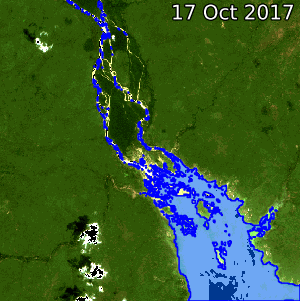

In [15]:
# Set vector features to a semi-transperant blue to represent water
poly_gdf['color'] = '#0066ff90'

# Produce time series animation 
xr_animation(ds=ds, 
             bands=['red', 'green', 'blue'],
             output_path='animated_timeseries.gif', 
             width_pixels=300,
             show_gdf=poly_gdf,
             gdf_kwargs={'edgecolor': 'blue'}) 

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')

## Custom image processing functions

The `image_proc_funcs` parameter allows you to pass custom image processing functions that will be applied to each frame of your animation as they are rendered. This can be a powerful way to produce visually appealing animations - some example applications include:

* Improving brightness, saturation or contrast
* Sharpening your images
* Histogram matching or equalisation

To demonstrate this, we will apply two functions from the [skimage.exposure](https://scikit-image.org/docs/dev/api/skimage.exposure.html) module which contains many powerful image processing algorithms:

1. `skimage.exposure.rescale_intensity` will first scale our data between 0.0 and 1.0 (required for step 2)
2. `skimage.exposure.equalize_adapthist` will take this re-scaled data and apply an alogorithm that will enhance and contrast local details of the image

> **Note:** Functions supplied to `image_proc_funcs` are applied one after another to each timestep in `ds` (e.g. each frame in the animation). 
Any custom function can be supplied to `image_proc_funcs`, providing it both **accepts and outputs** a `numpy.ndarray` with a shape of `(y, x, bands)`.
    
    

Applying custom image processing functions


  0%|          | 0/13 (0.0 seconds remaining at ? frames/s)

Exporting animation to animated_timeseries.gif


  0%|          | 0/13 (0.0 seconds remaining at ? frames/s)

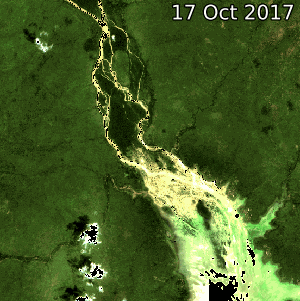

In [16]:
# Animate data after applying custom image processing functions to each frame
xr_animation(ds=ds.fillna(0), 
             bands=['red', 'green', 'blue'],
             output_path='animated_timeseries.gif',        
             width_pixels=300,
             image_proc_funcs=[skimage.exposure.rescale_intensity,                               
                               skimage.exposure.equalize_adapthist])

# Plot animated gifj
plt.close()
Image(filename='animated_timeseries.gif')


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [17]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [18]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-03-30'